##### import packages:

In [25]:
import pandas as pd
import datetime
import numpy as np
import urllib.request
import zipfile
import os
import matplotlib.pyplot as plt
# Time Series Clustering
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

##### download dataset and unzip file:

In [26]:
# only download if file does not exist yet:
if not os.path.exists('LD2011_2014.txt'):
    # Define URL
    URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
    # Download the file from `URL` and save it locally under `file_name`:
    urllib.request.urlretrieve(URL, "LD2011_2014.txt.zip")
    # Unzip file:
    zip_ref = zipfile.ZipFile("LD2011_2014.txt.zip", 'r')
    zip_ref.extractall()
    zip_ref.close()

##### read dataset:

In [27]:
# open raw file downloaded to local machine:
raw_file_path = 'LD2011_2014.txt'

# use raw file to read csv and get raw dataframe:
raw_dataset = pd.read_csv(raw_file_path, delimiter=';', header=0, decimal=',', index_col=False, low_memory=False)

# check dataframe info and head:
print(raw_dataset.info())
print(raw_dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Columns: 371 entries, Unnamed: 0 to MT_370
dtypes: float64(370), object(1)
memory usage: 397.0+ MB
None
            Unnamed: 0  MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  \
0  2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0   
1  2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0   
2  2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0   
3  2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0   
4  2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_007  MT_008  MT_009  ...  MT_361  MT_362  MT_363  MT_364  MT_365  \
0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
4  

##### convert strings of dates to datetime format:

In [28]:
# since column with datetime values doesn't have name, rename it to 'datetime':
data_timecol = raw_dataset.rename(columns={'Unnamed: 0':'datetime'})

# check dtypes for dataframe before converstion of 'datetime' column to datetime dtype:
print(data_timecol.dtypes)

# transform rennamed column into datetime dtype:
data_timecol['datetime'] = pd.to_datetime(data_timecol['datetime'], format=r'%Y-%m-%d %H:%M:%S')

# check if conversion was successful:
print(data_timecol.dtypes.value_counts())

datetime     object
MT_001      float64
MT_002      float64
MT_003      float64
MT_004      float64
             ...   
MT_366      float64
MT_367      float64
MT_368      float64
MT_369      float64
MT_370      float64
Length: 371, dtype: object
float64           370
datetime64[ns]      1
Name: count, dtype: int64


##### resample to hourly frequency:

In [29]:
# resample data from 15min level to hourly level:
data_resamp = data_timecol.resample('1H', on='datetime').sum().reset_index()

# get length of data_resamp:
data_resamp_length = len(data_resamp)

# check to see if resampling went through:
print(data_resamp.head())

             datetime  MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
0 2011-01-01 00:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1 2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2 2011-01-01 02:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3 2011-01-01 03:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4 2011-01-01 04:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_008  MT_009  ...  MT_361  MT_362  MT_363  MT_364  MT_365  MT_366  \
0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_367  MT_368  MT_369  MT_370  
0     0.0     0.0     0.0     0.

##### tidy dataframe by stacking it using melt:

In [30]:
resampled_data = data_resamp

# stack dataset by melting it (the value_name col will be recalculated after):
melted_data = pd.melt(resampled_data, id_vars=['datetime'], var_name='client_id', value_name='KwH')

# Remove 'MT_' from client_id col:
melted_data['client_id'] = melted_data['client_id'].str.replace('MT_', '').astype(int)
print(melted_data.head())

             datetime  client_id  KwH
0 2011-01-01 00:00:00          1  0.0
1 2011-01-01 01:00:00          1  0.0
2 2011-01-01 02:00:00          1  0.0
3 2011-01-01 03:00:00          1  0.0
4 2011-01-01 04:00:00          1  0.0


##### get rid of truncated rows (leading/trailing missing values):

In [31]:
# get min and max dates for each client_id:
cutoff_dates = melted_data[melted_data['KwH'] != 0].groupby('client_id', as_index=False).agg(
    min=('datetime','min'),
    max=('datetime','max')
    )

print(cutoff_dates.tail())
print(melted_data.head())

     client_id        min        max
365        366 2012-01-01 2015-01-01
366        367 2012-01-01 2015-01-01
367        368 2012-01-01 2015-01-01
368        369 2012-01-01 2015-01-01
369        370 2013-01-01 2015-01-01
             datetime  client_id  KwH
0 2011-01-01 00:00:00          1  0.0
1 2011-01-01 01:00:00          1  0.0
2 2011-01-01 02:00:00          1  0.0
3 2011-01-01 03:00:00          1  0.0
4 2011-01-01 04:00:00          1  0.0


In [32]:
# create copy of melted_data:
tmp = melted_data.copy()

# define function to filter rows before and after cutoff dates:
def filter_rows_before_after_date(df, cutoff_dates):
    df = df.merge(cutoff_dates, on='client_id', how='left')
    df['is_before_start'] = df['datetime'] < df['min']
    df['is_after_end'] = df['datetime'] > df['max']
    df.drop(df[df.is_before_start == True].index, inplace=True)
    df.drop(df[df.is_after_end == True].index, inplace=True)
    df.drop(['is_before_start', 'is_after_end', 'min', 'max'], axis=1, inplace=True)
    return df

# filter rows before and after cutoff dates:
melted_data = filter_rows_before_after_date(melted_data, cutoff_dates)
melted_data.head()

,datetime,client_id,KwH
8760,2012-01-01 00:00:00,1,12.690355
8761,2012-01-01 01:00:00,1,16.497462
8762,2012-01-01 02:00:00,1,19.035533
8763,2012-01-01 03:00:00,1,17.766497
8764,2012-01-01 04:00:00,1,19.035533


##### round numbers and check for zeros:

In [33]:
# get zero counts from original df to compare it to rounded one later:
hard_zero_counts = melted_data[melted_data['KwH'] == 0].groupby('client_id').size().sort_values(ascending=False)

# create new column 'KwH_round' round and round values to 2 decimals:
melted_data['KwH_round'] = melted_data['KwH'].round(2)

# check size of zero values in KwH_round column for each client_id:
zero_counts = melted_data[melted_data['KwH_round'] == 0].groupby('client_id').size()

# drop KwH_round column:
melted_data.drop('KwH_round', axis=1, inplace=True)

# sort values in descending order:
zero_counts = zero_counts.sort_values(ascending=False)

# get number of observations for each client_id:
client_counts = melted_data.groupby('client_id').size()

# combine zero_counts and client_counts into zero_counts_df:
zero_counts_df = pd.DataFrame({'zero_counts': zero_counts, 'client_counts': client_counts})

# create new column 'zero_counts_ratio' and calculate ratio of zero_counts to client_counts:
zero_counts_df['zero_counts_ratio'] = (zero_counts_df['zero_counts'] * 100 / zero_counts_df['client_counts']).round(2)

# sort values in descending order:
zero_counts_df = zero_counts_df.sort_values(by='zero_counts_ratio', ascending=False)

# check zero_counts_df:
print(zero_counts_df.head(20))

           zero_counts  client_counts  zero_counts_ratio
client_id                                               
347            15638.0          25981              60.19
132            19073.0          35065              54.39
130            14213.0          26305              54.03
348            12189.0          26304              46.34
131            15653.0          35065              44.64
133             1945.0           7041              27.62
15              2640.0          13811              19.12
66              2339.0          26305               8.89
127             1065.0          21937               4.85
288              523.0          35065               1.49
3                149.0          26305               0.57
178               23.0           4009               0.57
181               23.0           7249               0.32
337               23.0           8377               0.27
179               23.0           9049               0.25
123               50.0         

##### check if there is difference between 'rounded' zeros and python's 'non-rounded' zeros:

In [34]:
# check if index of hard_zero_counts is equal to zero_counts to perform join:
hard_zero_list = list(hard_zero_counts.index)
hard_zero_list.sort()
#print(len(hard_zero_list))
zero_list = list(zero_counts.index)
zero_list.sort()
#print(len(zero_list))
check_equality = (hard_zero_list == zero_list)
#print(check_equality)

# To join pandas Series, first we need to activate and populate its attribute 'name':
zero_counts.name = 'zero_counts'
hard_zero_counts.name = 'hard_zero_count'
zc_left = zero_counts.reset_index()
zc_right = hard_zero_counts.reset_index()
zc_merge = pd.merge(zc_left, zc_right, on='client_id')

# CONCLUSION: There is no difference between checking for zeros with 'unrounded' or 'rounded' values:
zc_merge['diff'] = zc_merge['zero_counts'].subtract(zc_merge['hard_zero_count'])
print(zc_merge.head())
print(zc_merge['diff'].isna().any())
print(zc_merge['diff'].value_counts())

   client_id  zero_counts  hard_zero_count  diff
0        132        19073            19073     0
1        131        15653            15653     0
2        347        15638            15638     0
3        130        14213            14213     0
4        348        12189            12189     0
False
diff
0    265
Name: count, dtype: int64


##### get dataframe for clients with high zero ratios:

In [35]:
# get index for clients with high zero_counts ratio:
zero_index = zero_counts_df.index[0:8]

print(zero_index)

# get melted_data_zero with client_id in zero_index:
melted_data_zero = melted_data[melted_data['client_id'].isin(zero_index)]

# check melted_data_zero:
print(melted_data_zero.head())

Index([347, 132, 130, 348, 131, 133, 15, 66], dtype='int32', name='client_id')
                  datetime  client_id         KwH
512164 2013-06-04 14:00:00         15   13.946281
512165 2013-06-04 15:00:00         15  193.698347
512166 2013-06-04 16:00:00         15  193.698347
512167 2013-06-04 17:00:00         15  196.280992
512168 2013-06-04 18:00:00         15  181.301653


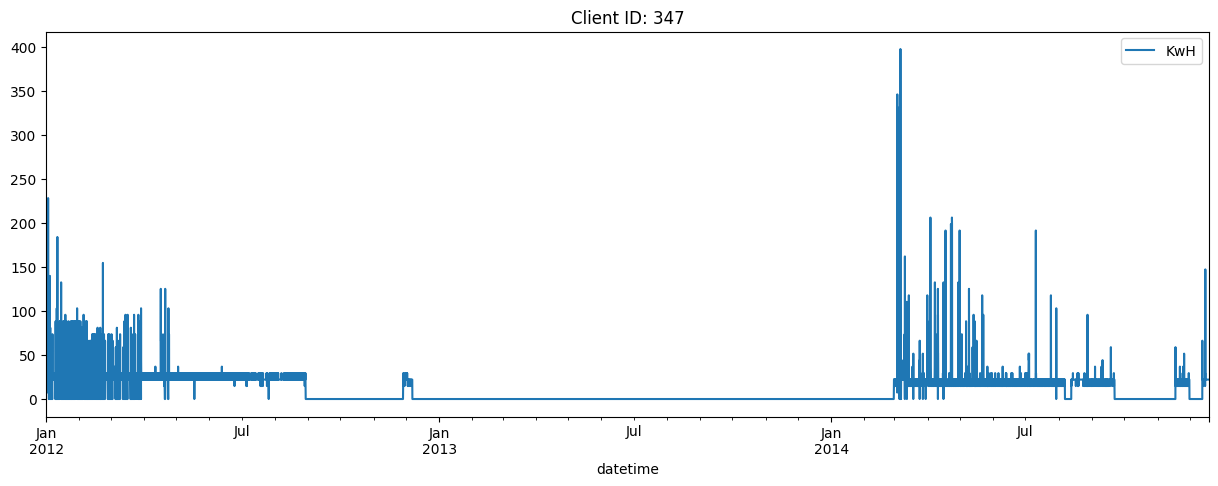

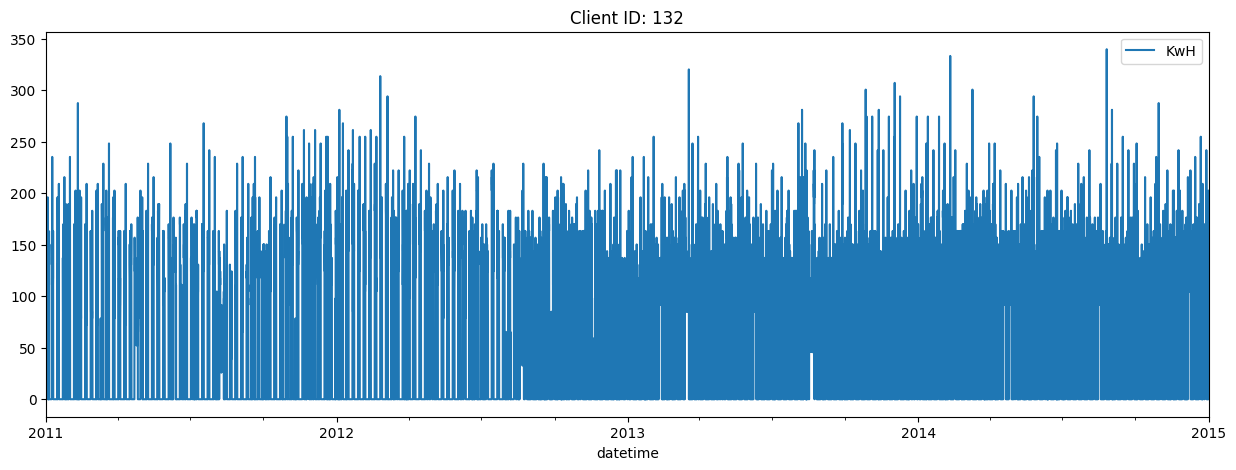

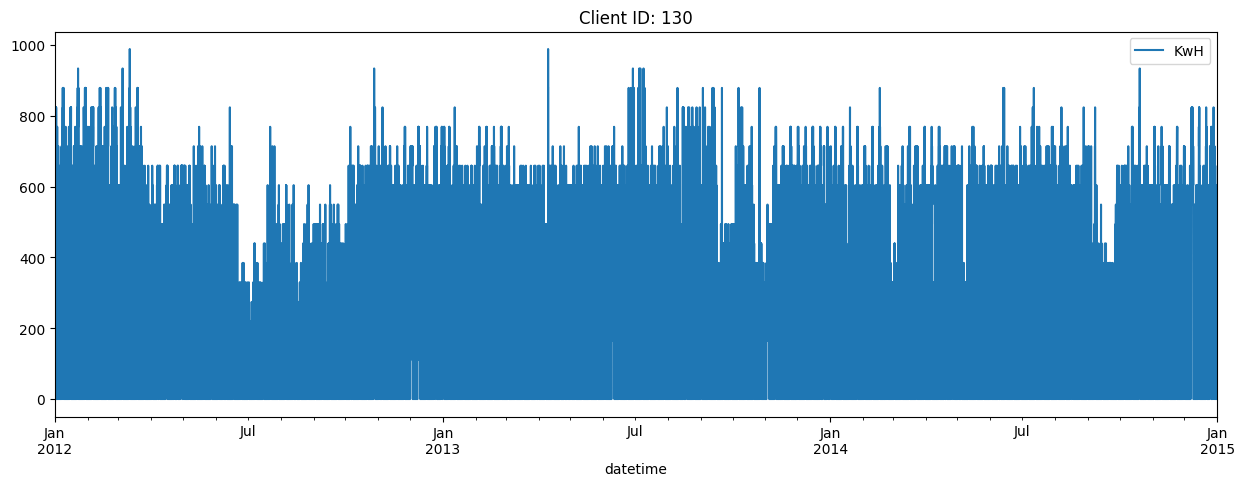

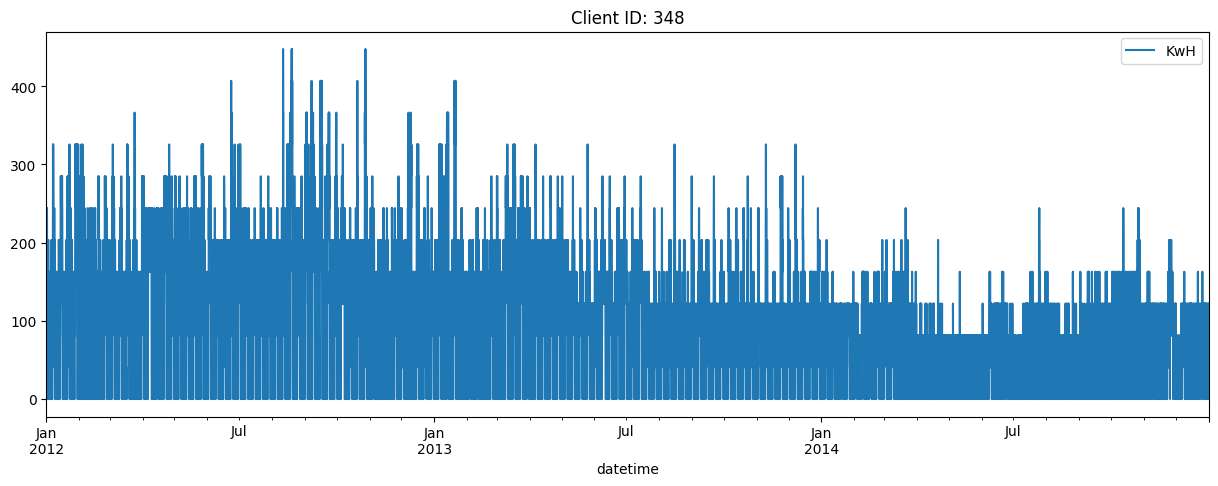

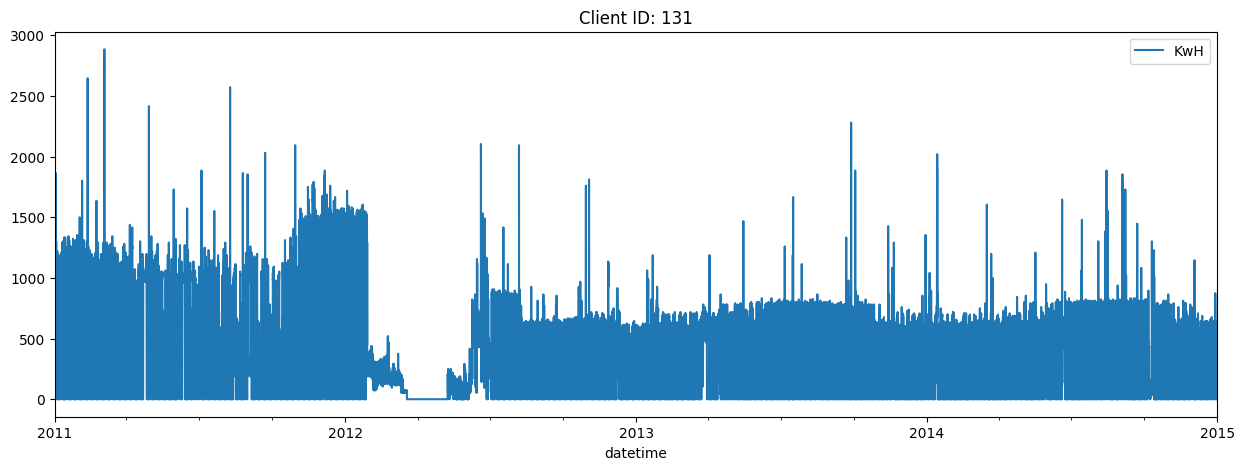

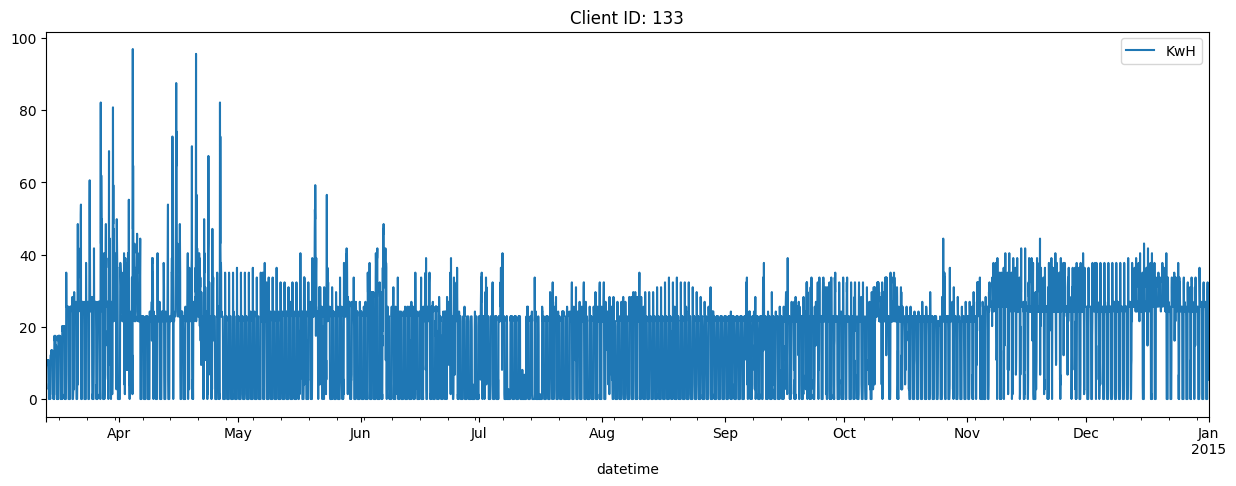

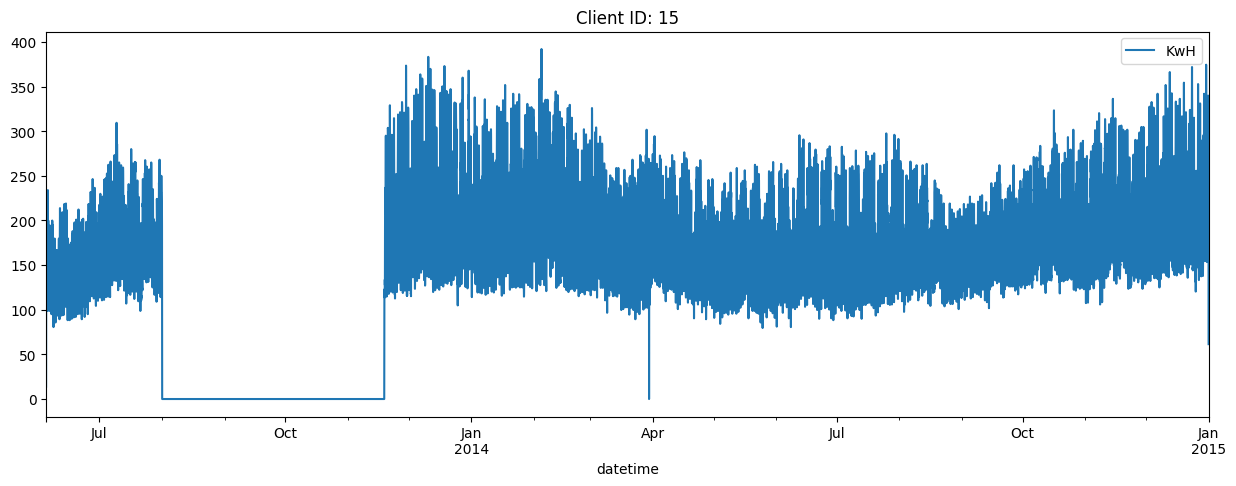

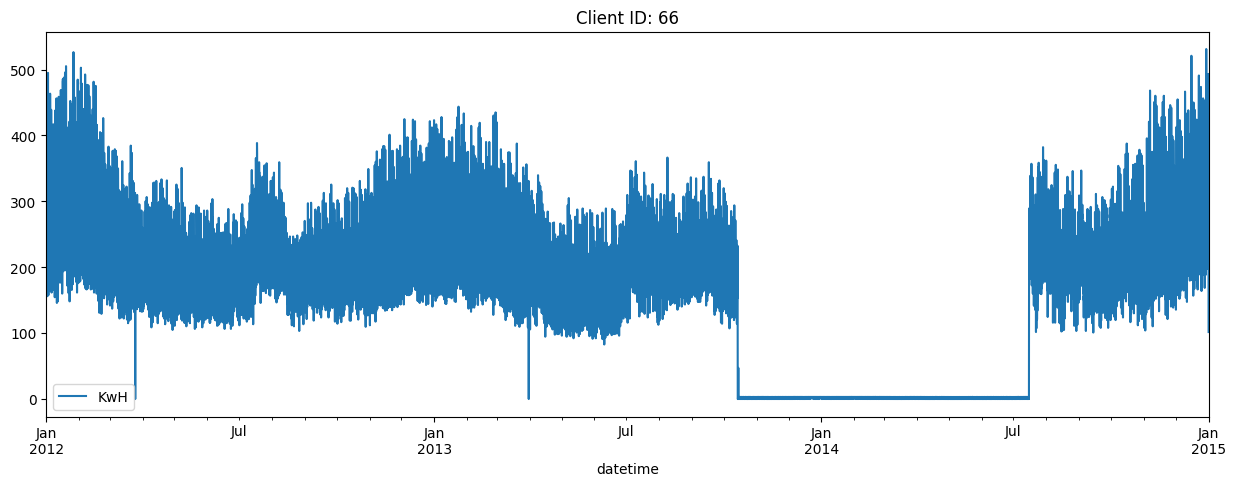

In [36]:
# plot melted_data_zero for each client_id:
for client_id in zero_index:
    melted_data_zero[melted_data_zero['client_id'] == client_id].plot(x='datetime', y='KwH', figsize=(15, 5))
    plt.title('Client ID: {}'.format(client_id))
    plt.show()

##### create daily moving average column:

In [37]:
# if 'mov_avg_24h' doesn't exist, create rolling window of 24 hours:
if 'mov_avg_24h' not in melted_data.columns:
    melted_data['mov_avg_24h'] = melted_data.groupby('client_id')['KwH'].rolling(24).mean().reset_index(0,drop=True)

# check data:
print(melted_data.tail(10))

                    datetime  client_id           KwH   mov_avg_24h
12974040 2014-12-31 15:00:00        370  57513.513514  70704.954955
12974041 2014-12-31 16:00:00        370  49837.837838  69198.198198
12974042 2014-12-31 17:00:00        370  46432.432432  67718.468468
12974043 2014-12-31 18:00:00        370  40540.540541  66141.891892
12974044 2014-12-31 19:00:00        370  35891.891892  64218.468468
12974045 2014-12-31 20:00:00        370  33621.621622  62430.180180
12974046 2014-12-31 21:00:00        370  33135.135135  60623.873874
12974047 2014-12-31 22:00:00        370  30378.378378  58765.765766
12974048 2014-12-31 23:00:00        370  27729.729730  56912.162162
12974049 2015-01-01 00:00:00        370   7135.135135  54317.567568


##### Use Case: Finding groups of clients with similar consumption patterns

* First Step: Apply Dynamic Time Warping (DTW) with DBA (Dynamic Barycenter Averaging) to find groups of clients with similar consumption patterns.
* Second Step: Apply K-Means to find groups of clients with similar consumption patterns. (Find optimal number of clusters)
* Third Step: Get a dataframe with clients' IDs and their respective groups.
* Fourth Step: Identify patterns of consumption for each group.

In [38]:
# Get most recent date in cutoff_dates['max']:
max_date = cutoff_dates['max'].max()
# filter clients with max_data prior to max_date:
non_active_clients_list = cutoff_dates[cutoff_dates['max'] < max_date]['client_id'].unique().tolist()
active_clients_list = set(cutoff_dates['client_id'].unique().tolist()) - set(non_active_clients_list)
active_clients = melted_data[
    melted_data['client_id'].isin(active_clients_list)
]    

# check active_clients:
print(active_clients.head())
print(active_clients['datetime'].min())
print(active_clients['datetime'].max())
print(active_clients['client_id'].nunique())

                datetime  client_id        KwH  mov_avg_24h
8760 2012-01-01 00:00:00          1  12.690355          NaN
8761 2012-01-01 01:00:00          1  16.497462          NaN
8762 2012-01-01 02:00:00          1  19.035533          NaN
8763 2012-01-01 03:00:00          1  17.766497          NaN
8764 2012-01-01 04:00:00          1  19.035533          NaN
2011-01-01 00:00:00
2015-01-01 00:00:00
367


##### save active_clients csv for later comparison with missing data algorithm:

In [39]:
# save active_clients to csv:
active_clients.to_csv('active_clients.csv', index=False)

##### divide clients by size based on mean and max for better visualization:

In [40]:
# read melted_data.csv as missing_data with first column as index:
missing_data = active_clients.copy()

# drop column 'mov_avg_24h':
missing_data = missing_data.drop(columns=['mov_avg_24h'])

# get cols 'client_id' and 'KwH':
miss_df = missing_data[['client_id', 'KwH']]

# rename column to 'values':
miss_df = miss_df.rename(columns={'KwH': 'values'})

# rename column id_col to 'id':
miss_df = miss_df.rename(columns={'client_id': 'id'})

# change 0 to NaN:
miss_df = miss_df.replace(0, np.nan)

# insert index starting at 1:
miss_df.insert(0, 'index', miss_df.index + 1)

# get length of df:
length = len(miss_df)
    
# create column with 1 and np.nan:
miss_df['bool'] = np.where(miss_df['values'].notnull(), 1, np.nan)

# create column with cumulative sum of chunks of missing data that restarts to 1 at each non-missing value:
miss_df['cumsum'] = miss_df['bool'].isnull().astype(int).groupby(miss_df['bool'].notnull().astype(int).cumsum()).cumsum()

# create col 'plus' with values from 'cumsum' added by 0.1 skiping 0s:
miss_df['plus'] = miss_df['cumsum'].where(miss_df['cumsum'] != 0, np.nan) + 0.1

# fill NaN with 0s:
miss_df['plus'] = miss_df['plus'].fillna(0)

# create col 'diff' with diff for 'plus' column:
miss_df['diff'] = miss_df['plus'].diff()

# create col 'start_index' that use .eq() for 1.1 in column 'diff' and return index values from 'index' column added by 1:
miss_df['start_index'] = miss_df[miss_df['diff'].eq(1.1)]['index']

# get diff of 'plus' column shifted one row up:
miss_df['diff_up'] = miss_df['plus'].diff().shift(-1)

# create col 'end_index' with index value if .lt(-1.1):
miss_df['end_index'] = miss_df[miss_df['diff_up'].le(-1.1)]['index']

# create column 'sum_1' with value for .eq(1) in 'cumsum' column:
miss_df['sum_1'] = miss_df[miss_df['cumsum'].eq(1)]['cumsum']

# create column 'sum_2' with value for .eq(2) in 'cumsum' column:
miss_df['sum_2'] = miss_df[miss_df['cumsum'].eq(2)]['cumsum']

# change column sum 2 one row up:
miss_df['sum_2'] = miss_df['sum_2'].shift(-1)

# fill NaN for cols 'sum_1' and 'sum_2' with 0s:
miss_df['sum_1'] = miss_df['sum_1'].fillna(0)
miss_df['sum_2'] = miss_df['sum_2'].fillna(0)

# create column 'diff_12' with diff for 'sum_1' and 'sum_2' columns:
miss_df['diff_12'] = miss_df['sum_1'] - miss_df['sum_2']

# create column 'start_index_one' with index value if .eq(1) in 'diff_12' column:
miss_df['start_index_one'] = miss_df[miss_df['diff_12'].eq(1)]['index']

# create column 'end_index_one' with same values as 'start_index_one' column:
miss_df['end_index_one'] = miss_df['start_index_one']

# fill 'end_index' with values from 'end_index_one' column olny when .eq(1) for 'end_index_one' column:
miss_df['end_index'] = np.where(miss_df['end_index_one'].eq(1), miss_df['end_index_one'], miss_df['end_index'])

# rename miss_df to start_end_df:
start_end_df = miss_df

# drop columns except 'id', 'start_index' and 'end_index':
start_end_df = start_end_df.drop(['values', 'bool', 'cumsum', 'plus', 'diff', 'diff_up', 'sum_1', 'sum_2', 'diff_12', 'start_index_one', 'end_index_one'], axis=1)

# name index 'idx':
start_end_df.index.name = 'idx'

# fill 0 with NaN except for col 'id': ***PROBLEM HERE!!! START_INDEX FOR ID 348 BECOMES 348!!!
start_end_df = start_end_df.replace(0, np.nan)

# drop rows with NaN on both columns:
start_end_df = start_end_df.dropna(how='all')

# save rows with equal values in new df 'one_missing_df', including 'id' column:
one_missing_df = start_end_df[start_end_df['start_index'] == start_end_df['end_index']]

# slice df 'start_end_df' to remove rows with equal values:
start_end_df = start_end_df[start_end_df['start_index'] != start_end_df['end_index']]

# split 'start_end_df' in two dfs including 'id' column:
start_df = start_end_df[['id', 'start_index']].copy()
end_df = start_end_df[['id', 'end_index']].copy()

# rename col 'id' from 'start_df' to 'id_start':
start_df = start_df.rename(columns={'id': 'id_start'})

# rename col 'id' from 'end_df' to 'id_end':
end_df = end_df.rename(columns={'id': 'id_end'})

# remove rows of 'start_df' with NaN in 'start_index' column, without considering column 'id_start':
start_df = start_df.dropna(subset=['start_index']).reset_index(drop=True)

# remove rows of 'end_df' with NaN in 'end_index' column, without considering column 'id_end':
end_df = end_df.dropna(subset=['end_index']).reset_index(drop=True)

# rejoin 'start_df' and 'end_df' in 'start_end_df':
start_end_df = pd.concat([start_df, end_df], axis=1)

# drop 'id_end' column:
start_end_df = start_end_df.drop(columns=['id_end'])

# rename 'id_start' column to 'id':
start_end_df = start_end_df.rename(columns={'id_start': 'id'})

# concat values from 'one_missing_df' to 'start_end_df' without columns names:
start_end_df = pd.concat([start_end_df, one_missing_df], axis=0, ignore_index=True)

# sort values by 'start_index' column:
start_end_df = start_end_df.sort_values(by='start_index')

# reset index:
start_end_df = start_end_df.reset_index(drop=True)

# add column 'count' with diff 'end_index' - 'start_index' + 1:
start_end_df['count'] = start_end_df['end_index'] - start_end_df['start_index'] + 1

# create col 'pct' using count div by length mul by 100 to get percentage:
start_end_df['pct'] = (start_end_df['count'] / length * 100).round(2)

# if exists, drop 'index' column:
start_end_df = start_end_df.drop(columns=['index'], errors='ignore')

# check:
start_end_df.head(20)

# concat values from 'one_missing_df' to 'start_end_df' without columns names:
start_end_df = pd.concat([start_end_df, one_missing_df], axis=0, ignore_index=True)

# sort values by 'start_index' column:
start_end_df = start_end_df.sort_values(by='start_index')

# reset index:
start_end_df = start_end_df.reset_index(drop=True)

# add column 'count' with diff 'end_index' - 'start_index' + 1:
start_end_df['count'] = start_end_df['end_index'] - start_end_df['start_index'] + 1

# create col 'pct' using count div by length mul by 100 to get percentage:
start_end_df['pct'] = (start_end_df['count'] / length * 100).round(2)

# subtract 1 from 'start_index' column and 'end_index' column:
start_end_df['start_index'] = start_end_df['start_index'] - 1
start_end_df['end_index'] = start_end_df['end_index'] - 1

# sort by 'count' grouped by 'id':
start_end_df = start_end_df.groupby('id').apply(lambda x: x.sort_values(['count'], ascending=False)).reset_index(drop=True)

# check:
start_end_df.head()

# insert column 'datetime_start' after 'start_index' column:
try:
    start_end_df.insert(2, 'datetime_start', '')
except:
    pass

# insert column 'datetime_end' after 'end_index' column:
try:
    start_end_df.insert(4, 'datetime_end', '')
except:
    pass

# using 'start_index' column from 'start_end_df' and index from 'melted_data.csv', get values from 'datetime' column and insert in 'datetime_start' column:
start_end_df['datetime_start'] = missing_data.loc[start_end_df['start_index'], 'datetime'].values

# same as above but for 'end_index' column:
start_end_df['datetime_end'] = missing_data.loc[start_end_df['end_index'], 'datetime'].values

# if exists, drop 'index' column:
start_end_df = start_end_df.drop(columns=['index'], errors='ignore')

# remove decimals from 'start_index', 'end_index' and 'count' columns:
start_end_df['start_index'] = start_end_df['start_index'].astype(int)
start_end_df['end_index'] = start_end_df['end_index'].astype(int)
start_end_df['count'] = start_end_df['count'].astype(int)

# transform columns 'datetime_start' and 'datetime_end' to datetime:
start_end_df['datetime_start'] = pd.to_datetime(start_end_df['datetime_start'])
start_end_df['datetime_end'] = pd.to_datetime(start_end_df['datetime_end'])

# remove duplicate rows:
start_end_df = start_end_df.drop_duplicates()

# save to csv 'missing_data.csv':
start_end_df.to_csv('missing_data.csv')

# check:
start_end_df.head(50)

,id,start_index,datetime_start,end_index,datetime_end,count,pct
0,1,22094,2013-07-09 14:00:00,22094,2013-07-09 14:00:00,1,0.0
1,1,31043,2014-07-17 11:00:00,31043,2014-07-17 11:00:00,1,0.0
2,1,31162,2014-07-22 10:00:00,31162,2014-07-22 10:00:00,1,0.0
4,1,31114,2014-07-20 10:00:00,31114,2014-07-20 10:00:00,1,0.0
6,1,31045,2014-07-17 13:00:00,31045,2014-07-17 13:00:00,1,0.0
9,1,31021,2014-07-16 13:00:00,31021,2014-07-16 13:00:00,1,0.0
12,1,30994,2014-07-15 10:00:00,30994,2014-07-15 10:00:00,1,0.0
14,1,30974,2014-07-14 14:00:00,30974,2014-07-14 14:00:00,1,0.0
16,1,30950,2014-07-13 14:00:00,30950,2014-07-13 14:00:00,1,0.0
18,1,31267,2014-07-26 19:00:00,31267,2014-07-26 19:00:00,1,0.0


##### test algorith by comparing test_missing_data and active_client's csvs (all random manually checked tests passed):

In [41]:
# create variable test_missing_data with copy of start_end_df with columns 'datetime_start', 'id', 'datetime_end', 'id' again:
test_missing_data = start_end_df[['datetime_start', 'id', 'datetime_end', 'id']].copy()

# save to test_missing_data.csv:
test_missing_data.to_csv('test_missing_data.csv', index=False)

based on the requirement of being able to visualize each client's data when plotted, mean and max values for each client where evaluated and the following groups where created:
- group highest (5): mean KwH > 45000 
- group high (4): mean KwH > 5500 
- group medium (3): mean KwH > 1500 
- group low (2): mean KwH > 500 
- group lowest (1): mean KwH <=500 lowest

In [42]:
# get average consumption for and max consumption for each client_id:
consumption_lvl = active_clients.groupby('client_id')['KwH'].agg(['mean', 'max']).round().astype(int)

# sort values in descending order of max consumption:
consumption_lvl = consumption_lvl.sort_values(by='mean', ascending=False).reset_index()

# create column lowest and assing value 1 for mean < 500:
consumption_lvl['lowest'] = np.where(consumption_lvl['mean'] < 500, 1, 0)

# create column low and assing value 2 for mean >= 500 and < 1500:
consumption_lvl['low'] = np.where((consumption_lvl['mean'] >= 500) & (consumption_lvl['mean'] < 1500), 2, 0)

# create column medium and assing value 3 for mean >= 1500 and < 5500:
consumption_lvl['medium'] = np.where((consumption_lvl['mean'] >= 1500) & (consumption_lvl['mean'] < 5500), 3, 0)

# create column high and assing value 4 for mean >= 5500 and <= 45000:
consumption_lvl['high'] = np.where((consumption_lvl['mean'] >= 5500) & (consumption_lvl['mean'] <= 45000), 4, 0)

# create column highest and assing value 5 for mean > 45000:
consumption_lvl['highest'] = np.where(consumption_lvl['mean'] > 45000, 5, 0)

# add columns lowest, low, medium, high and highest:
consumption_lvl['consumption_lvl'] = consumption_lvl['lowest'] + consumption_lvl['low'] + consumption_lvl['medium'] + consumption_lvl['high'] + consumption_lvl['highest']

# drop columns lowest, low, medium, high and highest:
consumption_lvl = consumption_lvl.drop(['lowest', 'low', 'medium', 'high', 'highest'], axis=1)

# check number of clients in each consumption_lvl:
print(consumption_lvl['consumption_lvl'].value_counts())

# check consumption_lvl:
print(consumption_lvl.head())

consumption_lvl
1    179
2    102
3     61
4     21
5      4
Name: count, dtype: int64
   client_id    mean     max  consumption_lvl
0        362  200523  764000                5
1        196   82974  203000                5
2        370   69823  113838                5
3        279   48155   79722                5
4        208   26647   55924                4


##### determine number of clusters, transform dataset, group clients with similar patterns:

In [43]:
# Let's get one week of data for each client:
active_clients_week = active_clients[active_clients['datetime'] >= max_date - pd.DateOffset(weeks=1)]

# transform active_clients dataframe into a numpy array with (n_ts_test, sz, d) format, that means: number of time series, their size and their dimensionality (1).
active_clients_tslearn_format = active_clients_week.groupby('client_id')['KwH'].apply(list).values.tolist()
active_clients_tslearn_format = np.array(active_clients_tslearn_format)
sz = active_clients_tslearn_format.shape[1]
active_clients_tslearn_format = active_clients_tslearn_format.reshape(-1, sz, 1)
active_clients_tslearn_format.shape

(367, 169, 1)

112.038 --> 82.388 --> 82.388 --> 
102.968 --> 73.673 --> 72.655 --> 71.257 --> 64.719 --> 59.466 --> 58.384 --> 58.164 --> 58.128 --> 58.123 --> 58.117 --> 58.117 --> 
88.558 --> 51.962 --> 50.474 --> 50.172 --> 50.075 --> 49.961 --> 49.933 --> 49.933 --> 
81.791 --> 49.228 --> 47.835 --> 47.531 --> 47.213 --> 46.957 --> 46.674 --> 46.528 --> 46.433 --> 46.404 --> 46.404 --> 
78.486 --> 46.297 --> 44.400 --> 43.958 --> 43.623 --> 43.445 --> 43.380 --> 43.376 --> 43.374 --> 43.374 --> 
64.380 --> 43.456 --> 42.141 --> 41.575 --> 41.412 --> 41.242 --> 41.121 --> 40.994 --> 40.990 --> 40.987 --> 40.983 --> 40.979 --> 40.976 --> 40.974 --> 40.974 --> 
61.290 --> 42.167 --> 40.341 --> 39.740 --> 39.547 --> 39.378 --> 39.233 --> 39.109 --> 39.074 --> 39.031 --> 39.003 --> 38.975 --> 38.918 --> 38.879 --> 38.852 --> 38.776 --> 38.724 --> 38.698 --> 38.664 --> 38.643 --> 38.638 --> 38.638 --> 
56.185 --> 39.666 --> 38.507 --> 37.934 --> 37.528 --> 37.265 --> 37.120 --> 37.034 --> 36.991 --> 3

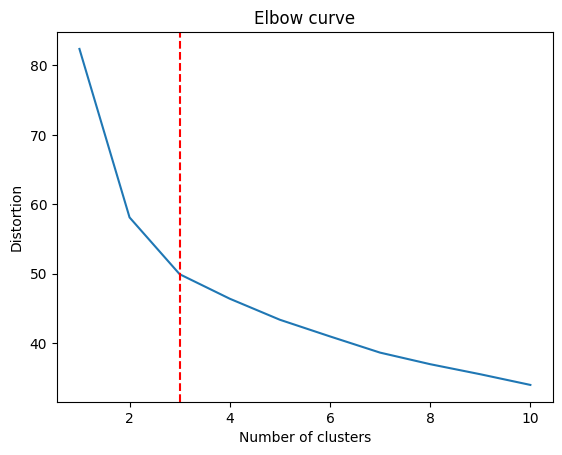

In [44]:
seed = 0
# Scale the data:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
active_clients_tslearn_format = scaler.fit_transform(active_clients_tslearn_format)

# determine optimal number of clusters:
distortions = []
for k in range(1, 11):
    kmeans = TimeSeriesKMeans(n_clusters=k, verbose=True, random_state=seed)
    kmeans.fit(active_clients_tslearn_format)
    distortions.append(kmeans.inertia_)

# plot elbow curve with vertical pointed line at number of clusters 3:
plt.plot(range(1, 11), distortions)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow curve')
plt.axvline(x=3, color='red', linestyle='--')
plt.show()


In [45]:
# create new dataframe with client_ids of active_clients:
client_df = pd.DataFrame(
    {'client_id': active_clients_week['client_id'].unique()}
)

# check client_df:
print(client_df.head())

km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(active_clients_tslearn_format)
client_df['client_groups'] = y_pred

   client_id
0          1
1          2
2          3
3          4
4          5
88.558 --> 51.962 --> 50.474 --> 50.172 --> 50.075 --> 49.961 --> 49.933 --> 49.933 --> 


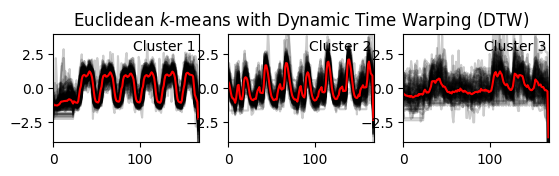

In [46]:
plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in active_clients_tslearn_format[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means with Dynamic Time Warping (DTW)")